In [ ]:
%pip install polars
%pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import gc
import polars as pl
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from tabulate import tabulate  # To display results in table format
from sklearn.metrics import mean_squared_error

In [2]:
# Load the dataset to understand its structure
csv_filename= pd.read_csv('all_stocks_5yr.csv')

# Display basic information about the dataset
csv_filename.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [54]:
# Load the original dataset
datastocks = "all_stocks_5yr.csv"  
df_original = pd.read_csv(datastocks)

# Benchmark function for evaluating CSV vs. Parquet
def benchmark(df, scale_factor, compression=None):
    """Evaluates CSV vs. Parquet in terms of size and speed at different scales."""
    scaled_df = pd.concat([df] * scale_factor, ignore_index=True)
    csv_filename = f"data_{scale_factor}x.csv"
    parquet_filename = f"data_{scale_factor}x.parquet"

    # ---- CSV Evaluation ----
    start_time = time.time()
    scaled_df.to_csv(csv_filename, index=False)
    csv_write_time = time.time() - start_time

    start_time = time.time()
    df_csv = pd.read_csv(csv_filename)
    csv_read_time = time.time() - start_time

    csv_size = os.path.getsize(csv_filename) / (1024 * 1024)  # Size in MB

    # ---- Parquet Evaluation ----
    start_time = time.time()
    scaled_df.to_parquet(parquet_filename, index=False, compression=compression, engine="pyarrow")
    parquet_write_time = time.time() - start_time

    start_time = time.time()
    df_parquet = pd.read_parquet(parquet_filename, engine="pyarrow")
    parquet_read_time = time.time() - start_time

    parquet_size = os.path.getsize(parquet_filename) / (1024 * 1024)  # Size in MB

    # Remove files to save space
    os.remove(csv_filename)
    os.remove(parquet_filename)

    # Clean Cache
    del scaled_df, df_csv, df_parquet  # to delete the dataframes
    gc.collect()  # to empty the cache

    # Return results    
    return {
        "Scale": scale_factor,
        "CSV_Size_MB": csv_size,
        "CSV_Write_Time_s": csv_write_time,
        "CSV_Read_Time_s": csv_read_time,
        "Parquet_Size_MB": parquet_size,
        "Parquet_Write_Time_s": parquet_write_time,
        "Parquet_Read_Time_s": parquet_read_time,
        "Compression": compression
    }

# Run benchmarks at scales 1x, 10x, 100x with different compression methods
scales = [1, 10, 100]
compressions = [None, "snappy", "gzip", "brotli"]
results = []

for scale in scales:
    for comp in compressions:
        results.append(benchmark(df_original, scale, comp))

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the benchmark results to a CSV file
results_df.to_csv("benchmark_csv_parquet.csv", index=False)

# Print the results in the Jupyter Notebook
print("\n=== CSV vs. Parquet Benchmark Results ===")
display(results_df)  # Display table in Jupyter Notebook


=== CSV vs. Parquet Benchmark Results ===


,Scale,CSV_Size_MB,CSV_Write_Time_s,CSV_Read_Time_s,Parquet_Size_MB,Parquet_Write_Time_s,Parquet_Read_Time_s,Compression
0,1,28.800573,1.744498,0.290820,12.730873,0.240295,0.080239,None
1,1,28.800573,1.388274,0.248281,10.151073,0.318887,0.093797,snappy
2,1,28.800573,1.372739,0.263308,8.058299,0.754728,0.090736,gzip
3,1,28.800573,1.634053,0.304246,7.755613,1.059373,0.099399,brotli
4,10,288.005407,14.792532,2.905405,118.028409,2.591053,0.743071,None
5,10,288.005407,17.212445,3.333902,95.354448,2.991426,0.794729,snappy
6,10,288.005407,17.884880,3.291981,75.976962,10.097118,0.805354,gzip
7,10,288.005407,18.352993,2.891467,73.180475,10.017375,0.818962,brotli
8,100,2880.053747,201.342551,36.028684,1178.436979,33.597701,9.590052,None
9,100,2880.053747,196.529372,39.503717,951.709143,28.276961,6.639698,snappy


## First Result


<div style="text-align: center;">
    <img src="1x.jpg" alt="first result" width="1000"/>
</div>

## PART1 B   Perfomance Pandas Vs Polars

In [ ]:
# Load Dataset in both Pandas and Polars
csv_file = "all_stocks_5yr.csv"

# Load with Pandas
df_pandas = pd.read_csv(csv_file)
df_pandas['date'] = pd.to_datetime(df_pandas['date'])
df_pandas = df_pandas.sort_values('date')

# Load with Polars
df_polars = pl.read_csv(csv_file)
df_polars = df_polars.with_columns(pl.col("date").str.to_date())

print("Dataset successfully loaded in both Pandas and Polars.")

# Save Polars DF for persistence
df_polars.write_parquet("all_stocks_5yr_polars.parquet")

### === Technical Indicators Calculation Functions === ###

# 1. Relative Strength Index (RSI)
def calculate_rsi_pandas(df, period=14):
    delta = df["close"].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_rsi_polars(df, period=14):
    df = df.with_columns((df["close"].diff()).alias("delta"))
    gain = df.with_columns(pl.when(df["delta"] > 0).then(df["delta"]).otherwise(0).alias("gain"))
    loss = df.with_columns(pl.when(df["delta"] < 0).then(-df["delta"]).otherwise(0).alias("loss"))
    avg_gain = gain["gain"].rolling_mean(period)
    avg_loss = loss["loss"].rolling_mean(period)
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 2. Money Flow Index (MFI)
def calculate_mfi_pandas(df, period=14):
    typical_price = (df["high"] + df["low"] + df["close"]) / 3
    money_flow = typical_price * df["volume"]
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
    mf_ratio = positive_flow.rolling(period).sum() / (negative_flow.rolling(period).sum() + 1e-10)
    mfi = 100 - (100 / (1 + mf_ratio))
    return mfi

def calculate_mfi_polars(df, period=14):
    typical_price = (df["high"] + df["low"] + df["close"]) / 3
    money_flow = typical_price * df["volume"]
    
    df = df.with_columns(
        (typical_price > typical_price.shift(1)).alias("positive_mask"),
        (typical_price < typical_price.shift(1)).alias("negative_mask")
    )
    
    positive_flow = money_flow * df["positive_mask"]
    negative_flow = money_flow * df["negative_mask"]
    
    positive_flow_sum = positive_flow.rolling_sum(period)
    negative_flow_sum = negative_flow.rolling_sum(period)
    
    mf_ratio = positive_flow_sum / (negative_flow_sum + 1e-10)
    mfi = 100 - (100 / (1 + mf_ratio))
    
    return mfi

# 3. Stochastics
def calculate_stoch_pandas(df, period=14):
    lowest_low = df["low"].rolling(window=period).min()
    highest_high = df["high"].rolling(window=period).max()
    stoch = 100 * (df["close"] - lowest_low) / (highest_high - lowest_low + 1e-10)
    return stoch

def calculate_stoch_polars(df, period=14):
    lowest_low = df["low"].rolling_min(period)
    highest_high = df["high"].rolling_max(period)
    stoch = 100 * (df["close"] - lowest_low) / (highest_high - lowest_low + 1e-10)
    return stoch

# 4. Moving Average Convergence Divergence (MACD)
def calculate_macd_pandas(df, short=12, long=26, signal=9):
    short_ema = df["close"].ewm(span=short, adjust=False).mean()
    long_ema = df["close"].ewm(span=long, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_macd_polars(df, short=12, long=26, signal=9):
    short_ema = df["close"].rolling_mean(short)
    long_ema = df["close"].rolling_mean(long)
    macd = short_ema - long_ema
    signal_line = macd.rolling_mean(signal)
    return macd, signal_line

### === Performance Benchmark === ###
results = []

def benchmark(func, df, label):
    """ Measure execution time of a function """
    start_time = time.time()
    result = func(df)
    exec_time = time.time() - start_time
    return {"Indicator": label, "Time (s)": exec_time}

# Run Benchmarks for Pandas
print("\nRunning calculations in Pandas...")
results.append(benchmark(lambda df: calculate_rsi_pandas(df), df_pandas, "RSI - Pandas"))
results.append(benchmark(lambda df: calculate_mfi_pandas(df), df_pandas, "MFI - Pandas"))
results.append(benchmark(lambda df: calculate_stoch_pandas(df), df_pandas, "Stochastic - Pandas"))
results.append(benchmark(lambda df: calculate_macd_pandas(df), df_pandas, "MACD - Pandas"))

# Run Benchmarks for Polars
print("\nRunning calculations in Polars...")
results.append(benchmark(lambda df: calculate_rsi_polars(df), df_polars, "RSI - Polars"))
results.append(benchmark(lambda df: calculate_mfi_polars(df), df_polars, "MFI - Polars"))
results.append(benchmark(lambda df: calculate_stoch_polars(df), df_polars, "Stochastic - Polars"))
results.append(benchmark(lambda df: calculate_macd_polars(df), df_polars, "MACD - Polars"))

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the benchmark results to a CSV file
results_df.to_csv("Benchmark_Pandas_Polars.csv", index=False)

# Create a comparison table
comparison_table = results_df.pivot_table(index="Indicator", values="Time (s)")

# Display Results
print("\n=== Performance Comparison: Pandas vs. Polars ===")
display(comparison_table)

import os

# Remove files to save space
try:
    if os.path.exists("all_stocks_5yr_polars.parquet"):
        os.remove("all_stocks_5yr_polars.parquet")
        print(f"Deleted all_stocks_5yr_polars.parquet to save space.")
except Exception as e:
    print(f"Error deleting all_stocks_5yr_polars.parquet: {e}")



Dataset successfully loaded in both Pandas and Polars.

Running calculations in Pandas...

Running calculations in Polars...

=== Performance Comparison: Pandas vs. Polars ===


,Time (s)
Indicator,
MACD - Pandas,0.022887
MACD - Polars,0.024914
MFI - Pandas,0.050522
MFI - Polars,0.043442
RSI - Pandas,0.040365
RSI - Polars,0.027666
Stochastic - Pandas,0.055411
Stochastic - Polars,0.031308


Deleted all_stocks_5yr_polars.parquet to save space.


# PART 2 Prediction Algoritms
* Using Linear Regression
* Random Forest 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from tabulate import tabulate  # To display results in table format

# Load dataset
csv_file = "all_stocks_5yr.csv"
df = pd.read_csv(csv_file)

# Convert date column to datetime and sort values
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Select three companies
selected_companies = ["AAPL", "GOOGL", "AMZN"]  # Example companies
df_selected = df.loc[df["name"].isin(selected_companies)]

# Initialize storage for results
results = []
r2_scores = []

# Process each company separately
for company in selected_companies:
    df_company = df_selected[df_selected["name"] == company].copy()

    # Create additional features
    df_company["SMA_10"] = df_company["close"].rolling(window=10).mean()  # 10-day moving average
    df_company["Volatility"] = df_company["close"].rolling(window=10).std()  # Standard deviation (volatility)

    # Drop NaN values from rolling calculations
    df_company = df_company.dropna()

    # Define features (X) and target (y)
    X = df_company[["close", "volume", "SMA_10", "Volatility"]]
    y = df_company["close"].shift(-1)  # Predict next day's closing price

    # Drop last row because it has NaN in y (shifted row)
    X, y = X[:-1], y[:-1]

    # Split into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Linear Regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    lin_reg_pred = lin_reg.predict(X_test)
    lin_reg_r2 = r2_score(y_test, lin_reg_pred)

    # Train Random Forest model
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(X_train, y_train)
    rf_reg_pred = rf_reg.predict(X_test)
    rf_reg_r2 = r2_score(y_test, rf_reg_pred)

    # Get the last available row for prediction
    last_row = X.iloc[-1].values.reshape(1, -1)
    predicted_lin = lin_reg.predict(last_row)[0]
    predicted_rf = rf_reg.predict(last_row)[0]

    # Store results
    last_date = df_company["date"].iloc[-1]
    actual_last_price = df_company["close"].iloc[-1]
    results.append([company, last_date, actual_last_price, predicted_lin, predicted_rf])
    r2_scores.append([company, lin_reg_r2, rf_reg_r2])

# Create table for predictions
print("\n=== Predicted Next Day Closing Price ===")
print(tabulate(results, headers=["Company", "Last Date", "Last Closing Price", "Linear Regression Prediction", "Random Forest Prediction"], tablefmt="grid"))

# Create table for R² comparison
print("\n=== R² Score Comparison ===")
print(tabulate(r2_scores, headers=["Company", "R² Linear Regression", "R² Random Forest"], tablefmt="grid"))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



=== Predicted Next Day Closing Price ===
+-----------+---------------------+----------------------+--------------------------------+----------------------------+
| Company   | Last Date           |   Last Closing Price |   Linear Regression Prediction |   Random Forest Prediction |
+===========+=====================+======================+================================+============================+
| AAPL      | 2018-02-07 00:00:00 |               159.54 |                        163.029 |                    161.516 |
+-----------+---------------------+----------------------+--------------------------------+----------------------------+
| GOOGL     | 2018-02-07 00:00:00 |              1055.41 |                       1081.65  |                   1073.54  |
+-----------+---------------------+----------------------+--------------------------------+----------------------------+
| AMZN      | 2018-02-07 00:00:00 |              1416.78 |                       1444.31  |                   1

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Graph Time Series

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: U

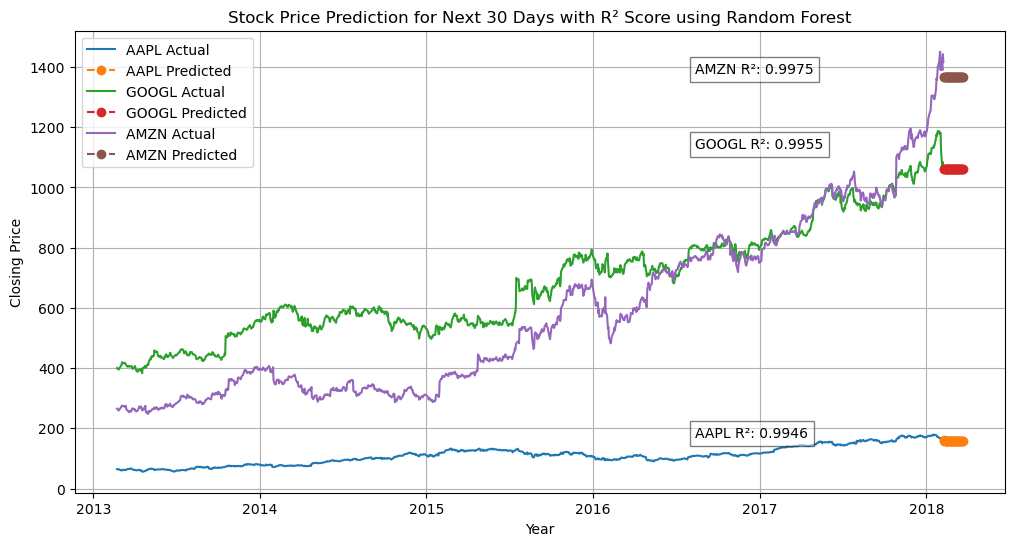

In [ ]:
# Load dataset
csv_file = "all_stocks_5yr.csv"  # Ensure the file is in the correct location
df = pd.read_csv(csv_file)

# Convert date column to datetime and sort values
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Select three companies
selected_companies = ["AAPL", "GOOGL", "AMZN"]
df_selected = df.loc[df["name"].isin(selected_companies)].copy()

# Initialize figure for plotting
plt.figure(figsize=(12, 6))

# Process each company separately
for company in selected_companies:
    df_company = df_selected[df_selected["name"] == company].copy()

    # Create additional features to prevent data leakage
    df_company["SMA_10"] = df_company["close"].rolling(window=10).mean()  # 10-day moving average
    df_company["Volatility"] = df_company["close"].rolling(window=10).std()  # Price volatility
    df_company["prev_close"] = df_company["close"].shift(1)
    df_company["prev_volume"] = df_company["volume"].shift(1)

    # Drop NaN values generated by rolling features
    df_company = df_company.dropna()

    # Define features (X) and target (y)
    X = df_company[["prev_close", "prev_volume", "SMA_10", "Volatility"]]
    y = df_company["close"]  # Predicting today's closing price

    # Split the data into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest model with improved hyperparameters
    rf_reg = RandomForestRegressor(n_estimators=200, max_depth=4, min_samples_split=20, random_state=42)
    rf_reg.fit(X_train, y_train)

    # Compute R² score
    y_pred_test = rf_reg.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)

    # Predict stock prices for the next 30 days
    future_dates = pd.date_range(df_company["date"].iloc[-1], periods=31, freq='B')[1:]
    future_predictions = []
    last_row = X.iloc[-1].values.reshape(1, -1)

    for i in range(30):
        pred_price = rf_reg.predict(last_row)[0]
        future_predictions.append(pred_price)
        last_row[0][0] = pred_price  # Update previous close with predicted value

    # Plot actual closing prices over time
    plt.plot(df_company["date"], df_company["close"], label=f"{company} Actual", linestyle="-")

    # Plot predicted prices for the next 30 days
    plt.plot(future_dates, future_predictions, marker="o", linestyle="dashed", label=f"{company} Predicted")

    # Add R² score as text in the plot
    plt.text(df_company["date"].iloc[int(len(df_company) * 0.7)], df_company["close"].max() * 0.95, 
             f"{company} R²: {r2:.4f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Formatting the plot
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.title("Stock Price Prediction for Next 30 Days with R² Score using Random Forest")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
